Group Member: Tian Wang U37376130,  Qiyue Sun U59404684,  Yuanbin Gao U76427068

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, split, col, length, when, size, lit, from_unixtime, to_date, avg, year
import string
import nltk
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**We first need to create a SparkSession (with maximum memory equals to 20g), and the detailed work flow can be view in the spark UI, http://localhost:4040**

In [4]:
MAX_MEMORY = "20g"
spark = SparkSession \
    .builder \
    .appName("AmazonReview1") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.ui.port", "4040") \
    .master("local[4]") \
    .getOrCreate()

In [5]:
spark

# **Compute average ratings in different industries and make a comparison**

**To address this question, we chose 6 different industries('Appliances', 'Baby_Products', 'Musical_Instruments', 'Industrial_and_Scientific', 'Software', 'Video_Games'), calculated their average ratings, and compared them by drawing a histogram to find the one with the highest rating.**

**Calculate the average rating for each data set**

In [6]:
df1 = spark.read.json('Appliances.jsonl')
avg1 = df1.select(F.avg("rating")).collect()[0][0]

df2 = spark.read.json('Baby_Products.jsonl')
avg2 = df2.select(F.avg("rating")).collect()[0][0]

df3 = spark.read.json('Musical_Instruments.jsonl')
avg3 = df3.select(F.avg("rating")).collect()[0][0]

df4 = spark.read.json('Industrial_and_Scientific.jsonl')
avg4 = df4.select(F.avg("rating")).collect()[0][0]

df5 = spark.read.json('Software.jsonl')
avg5 = df5.select(F.avg("rating")).collect()[0][0]

df6 = spark.read.json('Video_Games.jsonl')
avg6 = df6.select(F.avg("rating")).collect()[0][0]


**Then we plot the histogram**

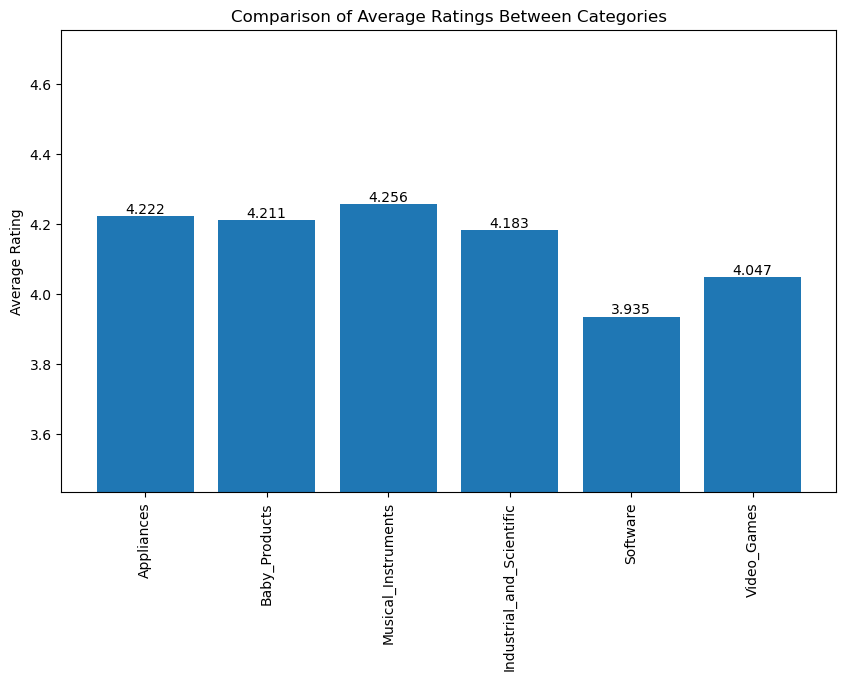

In [7]:
categories = ['Appliances', 'Baby_Products', 'Musical_Instruments', 'Industrial_and_Scientific', 'Software', 'Video_Games']
averages = [avg1, avg2, avg3, avg4, avg5, avg6]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, averages)
plt.ylabel('Average Rating')
plt.title('Comparison of Average Ratings Between Categories')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3),
             ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylim(min(averages) - 0.5, max(averages) + 0.5)
plt.show()

**As we can see, The Musical Instruments industry has the highest average rating(4.256), while the software industry has the lowest average rating(3.935). Meanwhile, the average rating for all 6 industries is around 4.0, indicating that customers are generally satisfied with the products in these industries.**

# **How ratings in different industries have trended over time**

**We are interested in observing how the ratings have evolved from May 1996 to Sep 2023 across six different industries. Therefore, we plan to use line graphs to reflect the trend changes in their ratings. Here, we use the yearly average rating to reflect their trend changes.**

In [8]:
df = spark.read.json('Appliances.jsonl')
df.printSchema()

df = df.withColumn("date", to_date(from_unixtime(col("timestamp") / 1000)))

df = df.withColumn("year", year("date"))

df.select("timestamp", "date", "year", "rating").show()

yearly_avg_rating_df = df.groupBy("year").agg(avg("rating").alias("avg_rating"))

yearly_avg_rating_df = yearly_avg_rating_df.orderBy("year")

yearly_avg_rating_df.show()


root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

+-------------+----------+----+------+
|    timestamp|      date|year|rating|
+-------------+----------+----+------+
|1519317108692|2018-02-22|2018|   5.0|
|1664746863446|2022-10-02|2022|   5.0|
|1607225435363|2020-12-06|2020|   5.0|
|1534104184306|2018-08-12|2018|   5.0|
|1620176603754|2021-05-05|2021|   5.0|
|1663078

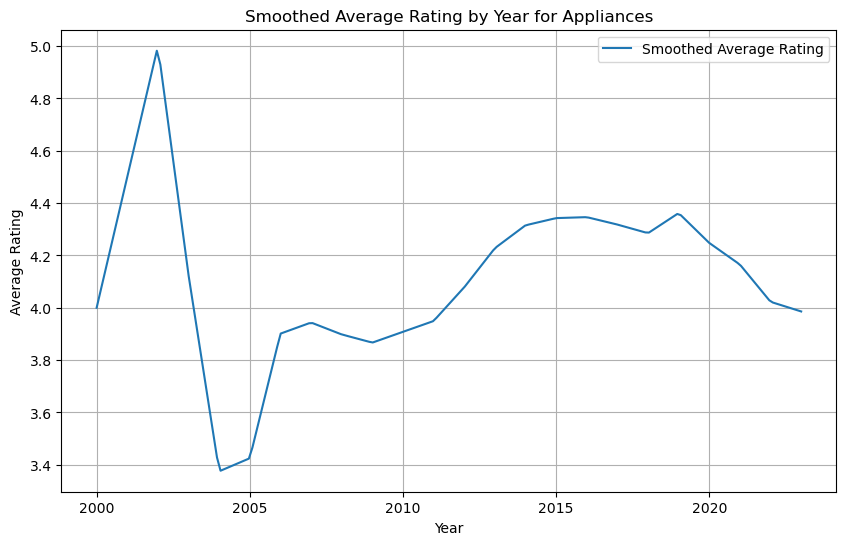

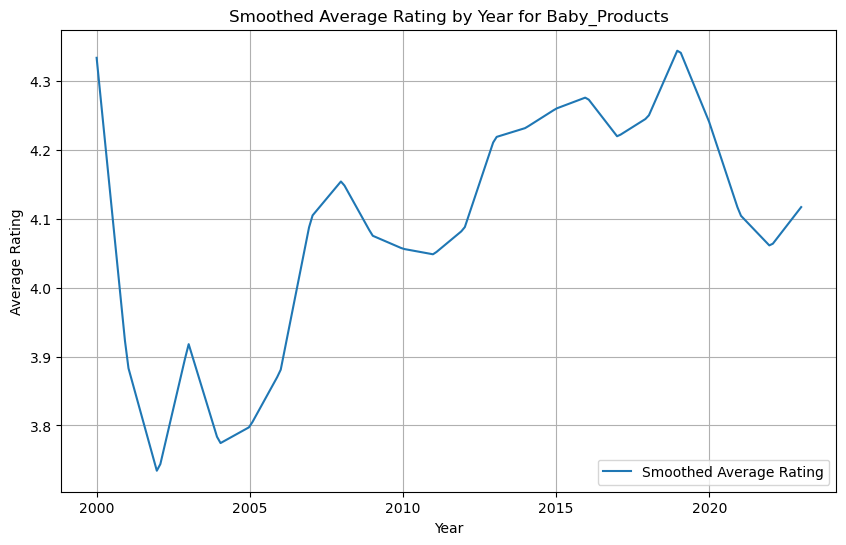

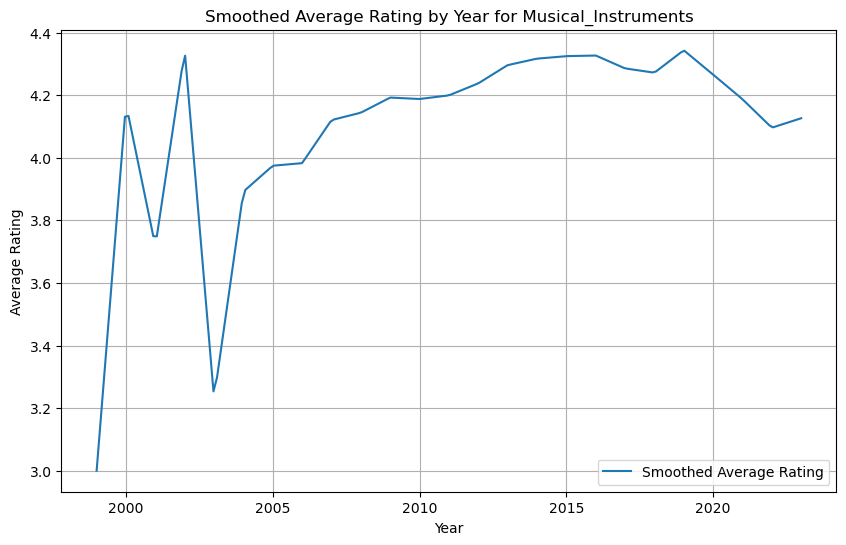

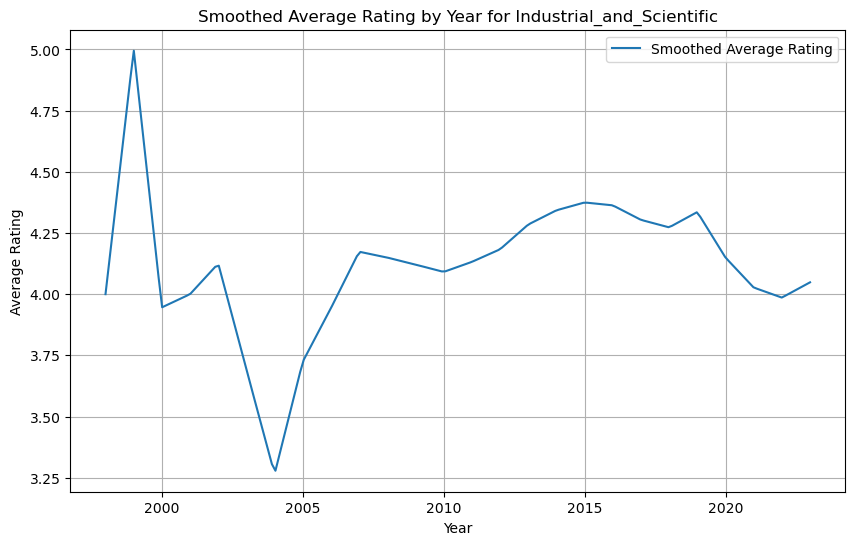

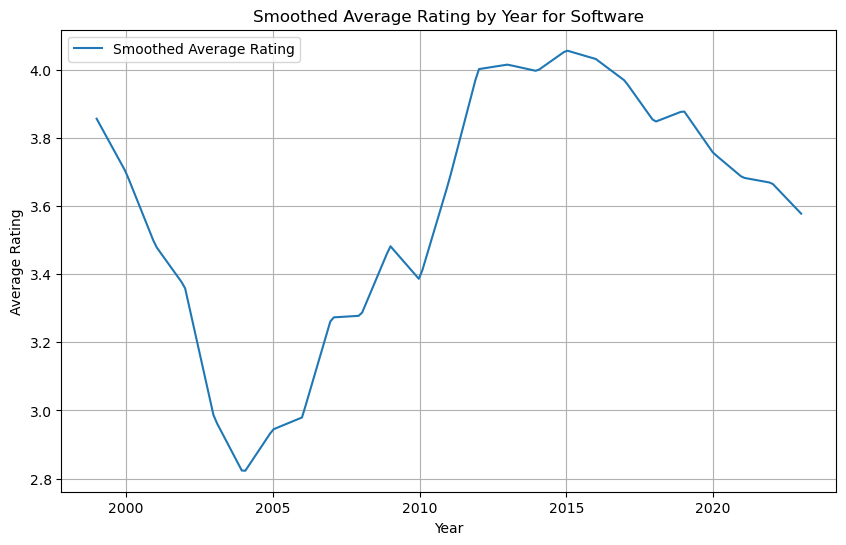

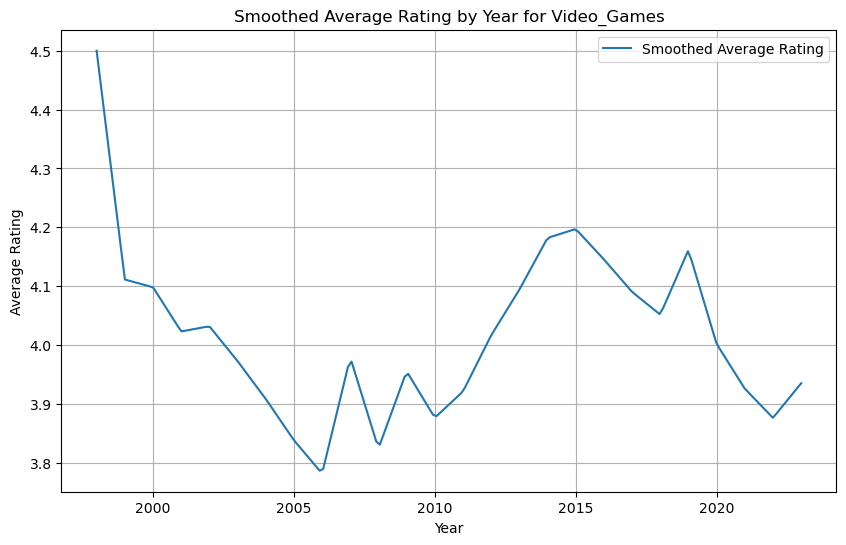

In [9]:
from scipy.interpolate import interp1d

def process_and_plot(df, title):
    df = df.withColumn("date", to_date(from_unixtime(col("timestamp") / 1000)))
    df = df.withColumn("year", year("date"))
    
    yearly_avg_rating_df = df.groupBy("year").agg(avg("rating").alias("avg_rating"))
    yearly_avg_rating_df = yearly_avg_rating_df.orderBy("year")

    pandas_df = yearly_avg_rating_df.toPandas()
    
    x = pandas_df['year']
    y = pandas_df['avg_rating']
    if len(x) > 1:  
        f = interp1d(x, y, kind='linear')
        xnew = np.linspace(x.min(), x.max(), num=200, endpoint=True)
        ynew = f(xnew)
    else:
        xnew = x
        ynew = y
    
    plt.figure(figsize=(10, 6))
    plt.plot(xnew, ynew, '-', label='Smoothed Average Rating')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.grid(True)
    plt.legend()
    plt.show()

process_and_plot(df1, 'Smoothed Average Rating by Year for Appliances')

process_and_plot(df2, 'Smoothed Average Rating by Year for Baby_Products')

process_and_plot(df3, 'Smoothed Average Rating by Year for Musical_Instruments')

process_and_plot(df4, 'Smoothed Average Rating by Year for Industrial_and_Scientific')

process_and_plot(df5, 'Smoothed Average Rating by Year for Software')

process_and_plot(df6, 'Smoothed Average Rating by Year for Video_Games')


**As we can see, the fluctuations in ratings between different years are quite significant. We have smoothed these line graphs to better visualize the trends.**

**Now we want to put them in the same line chart to make comparisons easier.**

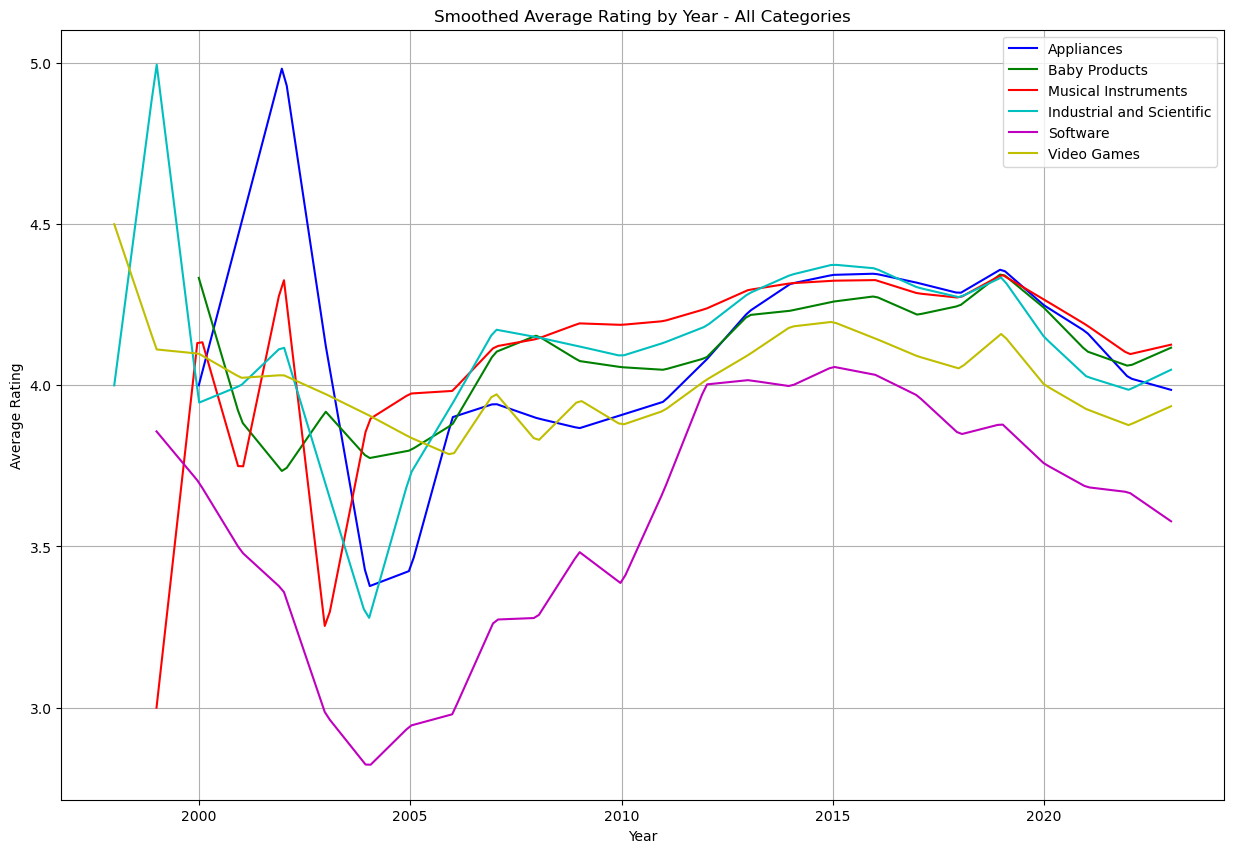

In [10]:
def process_data(df):
    df = df.withColumn("date", to_date(from_unixtime(col("timestamp") / 1000)))
    df = df.withColumn("year", year("date"))
    yearly_avg_rating_df = df.groupBy("year").agg(avg("rating").alias("avg_rating"))
    return yearly_avg_rating_df.toPandas()

def plot_all_categories():
    categories = [
        ("Appliances.jsonl", "Appliances"),
        ("Baby_Products.jsonl", "Baby Products"),
        ("Musical_Instruments.jsonl", "Musical Instruments"),
        ("Industrial_and_Scientific.jsonl", "Industrial and Scientific"),
        ("Software.jsonl", "Software"),
        ("Video_Games.jsonl", "Video Games")
    ]
    plt.figure(figsize=(15, 10))
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for (file, label), color in zip(categories, colors):
        df = spark.read.json(file)
        data = process_data(df)
        x = data['year']
        y = data['avg_rating']
        if len(x) > 1:
            f = interp1d(x, y, kind='linear')
            xnew = np.linspace(x.min(), x.max(), num=200, endpoint=True)
            ynew = f(xnew)
        else:
            xnew = x
            ynew = y
        
        plt.plot(xnew, ynew, '-', color=color, label=label)
    
    plt.title('Smoothed Average Rating by Year - All Categories')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_all_categories()


**The graph above represents a comparison of average ratings across different Amazon industries from May 1996 to Sep 2023. Some industry categories were not established in earlier years, resulting in missing data for those periods.   
From the graph, it can be observed that the ratings across the 6 different industries fluctuated significantly between May 1996 and 2006. However, in subsequent years, the fluctuations have become relatively more stable, and the overall ratings are generally consistent across industries, with the exception of software.   
Notably, the software industry has consistently experienced larger fluctuations in its ratings. Additionally, compared to other industries, the ratings of software have been relatively lower. I think rapid technological changes may contribute to this phenomenon. The software industry is characterized by rapid innovation and frequent updates. Products may quickly become obsolete, and new features or updates may not always meet user expectations, leading to varied ratings over time.**

# **Price distribution in different industries**

**We would like to investigate the differences in price distribution across various industries. Therefore, we have created bar charts to illustrate the price distribution across different industries.**

**The original data was initially too messy and complex to be directly read by Spark, leading to an `AnalysisException`: `[COLUMN_ALREADY_EXISTS] The column assembly required already exists. Consider choosing another name or renaming the existing column.` We addressed this issue by filtering out the useful information and customizing a cleaner schema to organize and handle the redundant data.**

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             46726|
|   mean|  86.4799539034291|
| stddev|325.31839674168447|
|    min|              0.01|
|    max|          21095.62|
+-------+------------------+



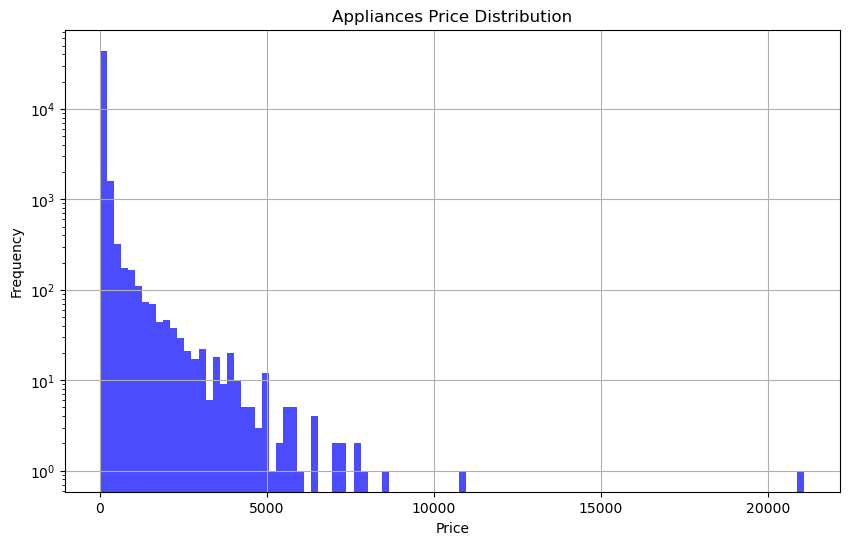

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            60256|
|   mean|36.52265900535272|
| stddev|78.91908892148736|
|    min|             0.01|
|    max|          6500.99|
+-------+-----------------+



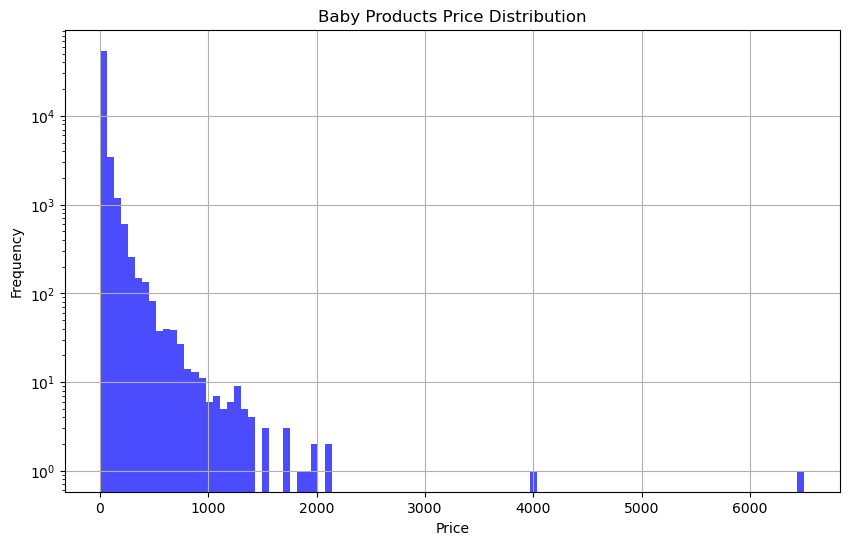

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             84878|
|   mean|127.70641844934617|
| stddev| 314.5349540008392|
|    min|               0.0|
|    max|           18990.0|
+-------+------------------+



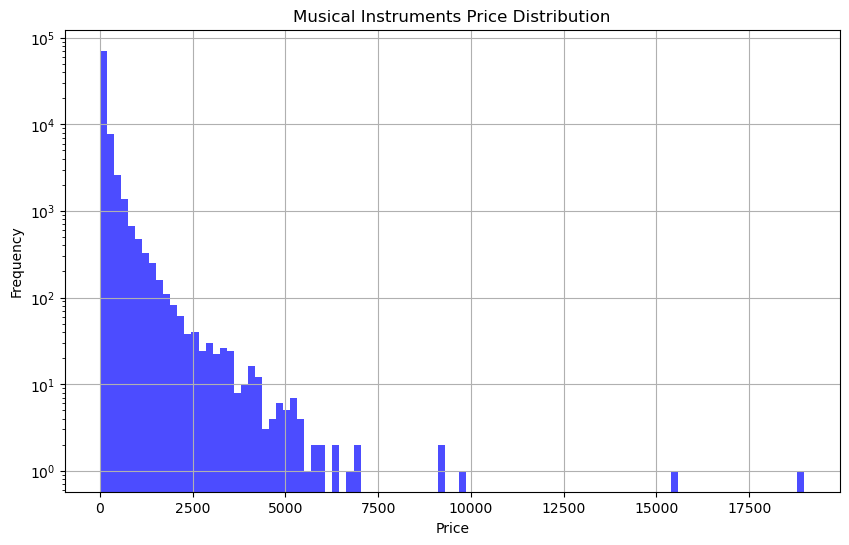

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           222943|
|   mean|60.79473138875282|
| stddev|471.5059340085813|
|    min|             0.01|
|    max|        129266.64|
+-------+-----------------+



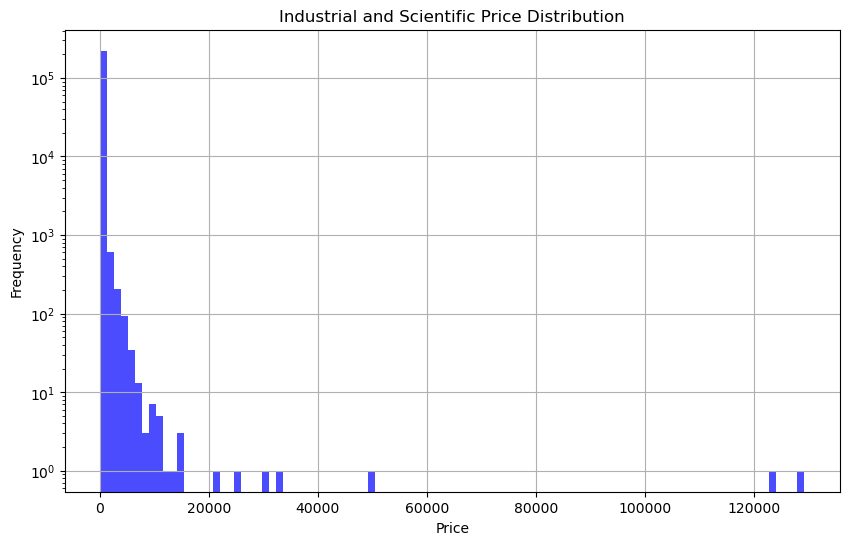

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             70985|
|   mean|2.9567242368566373|
| stddev|25.546928583752166|
|    min|               0.0|
|    max|            1998.0|
+-------+------------------+



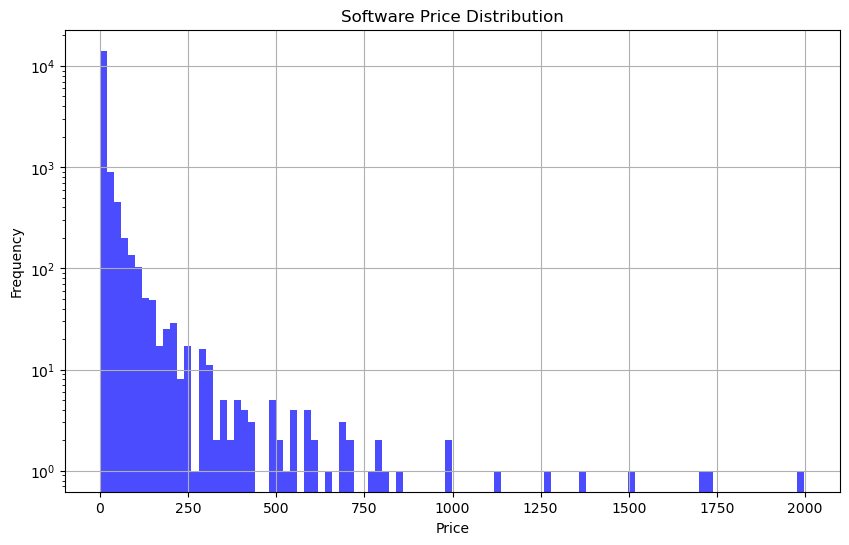

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            61972|
|   mean|45.71735187750276|
| stddev|82.98245946561168|
|    min|              0.0|
|    max|          3499.99|
+-------+-----------------+



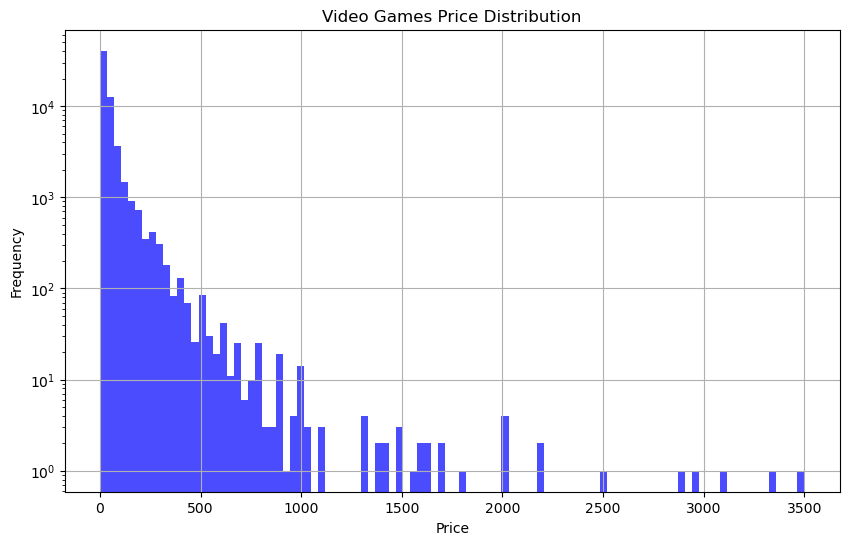

In [11]:
from pyspark.sql.types import *

def analyze_price_distribution(industry_name, file_path):
   
    schema = StructType([
        StructField("main_category", StringType(), True), 
        StructField("title", StringType(), True), 
        StructField("average_rating", FloatType(), True),
        StructField("rating_number", IntegerType(), True),
        StructField("features", ArrayType(StringType(), containsNull=True), True),
        StructField("description", ArrayType(StringType(), containsNull=True), True),
        StructField("price", FloatType(), True),
        StructField("store", StringType(), True),
        StructField("parent_asin", StringType(), True),
    ])

    df = spark.read.schema(schema).json(file_path)

    df.describe("price").show()

    df_filtered = df.filter(df.price > 0)

    pandas_df = df_filtered.select("price").toPandas()

    plt.figure(figsize=(10, 6))
    plt.hist(pandas_df['price'], bins=100, color='blue', alpha=0.7, log=True)
    plt.title(f'{industry_name} Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


analyze_price_distribution("Appliances", "meta_Appliances.jsonl")
analyze_price_distribution("Baby Products", "meta_Baby_Products.jsonl")
analyze_price_distribution("Musical Instruments", "meta_Musical_Instruments.jsonl")
analyze_price_distribution("Industrial and Scientific", "meta_Industrial_and_Scientific.jsonl")
analyze_price_distribution("Software", "meta_Software.jsonl")
analyze_price_distribution("Video Games", "meta_Video_Games.jsonl")

spark.stop()

**Each industry's price summary and distribution are shown above. As we can see, the Industrial and Scientific industry exhibits the largest price range, from `$0.01` to `$129,266.64`, and also has the highest variance among the industries, meaning that products in the Industrial and Scientific industry vary more significantly in cost compared to those in other industries. Conversely, the Software industry shows the smallest price range, from `$0.00` to `$1,998.0`.  
Due to the low frequency of some price values, I adjusted the histogram's bins parameter and employed a logarithmic scale. This reduces the impact of high values on the overall visual presentation, allowing the data with lower frequencies to be clearly displayed on the chart.**

# **We now move to the sentiment and regression analysis, we will first treate each industry as a whole to do the entire analysis, and we have six industies data in total (six different .jsonl files).**

We will use the 'dict.csv' file as a base dictionary for positive and negative words and do our sentiment analysis.

In [12]:
!wget -O dict.csv --no-check-certificate -r https://drive.google.com/uc?export=download\&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik

will be placed in the single file you specified.

--2024-05-02 01:04:28--  https://drive.google.com/uc?export=download&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik
Resolving drive.google.com (drive.google.com)... 142.250.65.206, 2607:f8b0:4006:80f::200e
Connecting to drive.google.com (drive.google.com)|142.250.65.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download [following]
--2024-05-02 01:04:29--  https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.40.225, 2607:f8b0:4006:823::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.40.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8880507 (8.5M) [application/octet-stream]
Saving to: ‘dict.csv’

dict.csv            100%[====

In [13]:
MAX_MEMORY = "20g"
spark = SparkSession \
    .builder \
    .appName("AmazonReview2") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.ui.port", "4040") \
    .master("local[4]") \
    .getOrCreate()

In [14]:
stop_words = set(stopwords.words('english'))
stop_words_df = spark.createDataFrame([(word,) for word in stop_words], ["word"])

punc = string.punctuation
nums = '1234567890'

In [15]:
pos_list = []
neg_list = []

lmmd = pd.read_csv('dict.csv')
lmmd_pos = lmmd.loc[lmmd.Positive>0]
lmmd_pos = set(lmmd_pos.Word)
lmmd_neg = lmmd.loc[lmmd.Negative>0]
lmmd_neg = set(lmmd_neg.Word)

### Define some functions for generic usage.

Function to read the .jsonl file using spark and check for the missing data:

In [16]:
def get_spark_data(filename):
    df = spark.read.format('json').load(filename)
    # simply review the data
    df.show()
    # check for the missing value, notes that when there is no image attached, the data puts an empty list to represent this situation
    for column in df.columns:
        missing_values = df.filter(col(column).isNull()).count()
        print(f"Number of missing values in {column}: {missing_values}")
    return df

Function to get the 'text' column and turn it into a RDD word count:

In [17]:
def text_to_rdd(df): 
    text_rdd = df.select("text").rdd.flatMap(lambda row: re.split(r'\W+', row[0]))
    word_count = text_rdd \
        .filter(lambda word: word != "") \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a + b)
    return word_count 

Functions for calculating the length of the review and the title, as well as transfer the images col to binary for later regression usage:

In [18]:
def cal_length(df):
    df_with_length = df.withColumn('review_len',length('text'))
    df_with_length = df_with_length.withColumn('title_len',length('title'))
    df_with_length = df_with_length.withColumn("binary_images", when(size(col('images')) == 0, 0).otherwise(1))

    return df_with_length

Function not in use.

In [19]:
# def frequencies_plot(word_count):
#     frequencies = word_count \
#         .filter(lambda x: x[0].lower() not in stop_words) \
#         .map(lambda x: (len(x[0]), 1)) \
#         .reduceByKey(lambda a, b: a + b) \
#         .collect()
#     df_fre = pd.DataFrame(frequencies, columns=["word_length", "word_count"])
#     plt.xlim(0,20)
#     plt.bar(x=df_fre.word_length, height=df_fre.word_count)

MapReduce technique for ranking the words by its frequency. Higher rank means that the word is mostly used within the reviews of specific industry, which excludes the stop words, punctuations, numbers from the entire words count and sort them by the occurence frequency (descending):

In [20]:
def top_word_count(word_count):
    top_count = word_count \
        .filter(lambda x: x[0].lower() not in stop_words) \
        .filter(lambda x: x[0].lower() not in punc) \
        .filter(lambda x: x[0].lower() not in nums) \
        .map(lambda x: (x[1], x[0])) \
        .sortByKey(ascending=False) \

    return top_count

Function for collecting all the reviews as a whole to get the frequencies of the positive words, for the subsequent sentiment analysis:

In [21]:
def count_pos(df):
    text_rdd = df.select("text").rdd.flatMap(lambda row: re.split(r'\W+', row[0]))
    counts_pos = text_rdd \
        .flatMap(lambda line: line.strip().split(" ")) \
        .filter(lambda word: word != "") \
        .filter(lambda x: x.upper() in lmmd_pos) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a + b)
    poss = counts_pos.collect()
    num_pos = counts_pos.map(lambda x: x[1]).sum()
    return poss, num_pos

Function for collecting all the reviews as a whole to get the frequencies of the negative words, for the subsequent sentiment analysis:

In [22]:
def count_neg(df):
    text_rdd = df.select("text").rdd.flatMap(lambda row: re.split(r'\W+', row[0]))
    counts_neg = text_rdd \
        .flatMap(lambda line: line.strip().split(" ")) \
        .filter(lambda word: word != "") \
        .filter(lambda x: x.upper() in lmmd_neg) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a + b)
    neg = counts_neg.collect()
    num_neg = counts_neg.map(lambda x: x[1]).sum()
    return neg, num_neg

### Industry 1: Appliances

In [23]:
Appliances = get_spark_data('Appliances.jsonl')

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B01N0TQ0OH|           0|    []| B01N0TQ0OH|   5.0|work great. use a...|1519317108692|          Work great|AGKHLEW2SOWHNMFQI...|             true|
|B07DD2DMXB|           0|    []| B07DD37QPZ|   5.0|Little on the thi...|1664746863446|   excellent product|AHWWLSPCJMALVHDDV...|             true|
|B082W3Z9YK|           0|    []| B082W3Z9YK|   5.0|Quick delivery, f...|1607225435363|     Happy customer!|AHZIJGKEWRTAEOZ67...|             true|
|B078W2BJY8|           0|    []| B078W2BJY8|   5.0|I wasn't sure whe...|1534104184306|       Amazing value|AFGUPTDFAWO

In [24]:
Appliances_word_count = text_to_rdd(Appliances)

In [25]:
Appliances_top = top_word_count(Appliances_word_count)
Appliances_top.take(20)

[(528197, 'br'),
 (333185, 'great'),
 (320717, 'one'),
 (279792, 'water'),
 (261621, 'filter'),
 (250867, 'fit'),
 (232736, 'use'),
 (228515, 'easy'),
 (228467, 'product'),
 (227672, 'ice'),
 (226416, 'like'),
 (219038, 'coffee'),
 (208620, 'good'),
 (190179, 'well'),
 (187304, 'install'),
 (186205, 'works'),
 (181040, 'would'),
 (169963, 'time'),
 (169173, 'price'),
 (162028, 'work')]

In [26]:
Appliances_pos, Appliances_pos_sum = count_pos(Appliances)
Appliances_neg, Appliances_neg_sum = count_neg(Appliances)

In [27]:
print(Appliances_pos_sum)
print(Appliances_neg_sum)

1470893
709902


According to the results, it seems that the reviews are generally more positive and we will check the average rating of this industry product to further check it.

In [28]:
Appliances_avg = Appliances.select(F.avg('rating'))
Appliances_avg.show()

+-----------------+
|      avg(rating)|
+-----------------+
|4.221502345432807|
+-----------------+



The average rating of 'Appliances' is 4.22 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

### Industry 2: Baby_Products

In [29]:
BP = get_spark_data('Baby_Products.jsonl')

+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B004FM7VOW|           1|                  []| B089MS68G8|   4.0|I bought two of t...|1471546337000|Good buy for pres...|AGKASBHYZPGTEPO6L...|             true|
|B01E5E703G|           1|                  []| B01E5E703G|   5.0|LOVE THESE! AND T...|1471542244000|THEY WORK- and ar...|AGKASBHYZPGTEPO6L...|             true|
|B00F463XV8|           0|                  []| B00F9386Q8|   1.0|cute but small an...|1452650881000|cute but small an...|AGKASBHYZPGTEPO6L...|             true|
|B0007V644S|           0|         

In [30]:
BP_word_count = text_to_rdd(BP)

In [31]:
BP_top = top_word_count(BP_word_count)
BP_top.take(20)

[(1615512, 'br'),
 (1231598, 'baby'),
 (1079740, 'one'),
 (1031148, 'great'),
 (1007230, 'use'),
 (884780, 'like'),
 (848190, 'easy'),
 (768339, 'love'),
 (721930, 'would'),
 (690777, 'well'),
 (688746, 'product'),
 (684129, 'little'),
 (610506, 'get'),
 (597860, 'old'),
 (562590, 'good'),
 (510378, 'really'),
 (502006, 'seat'),
 (495798, 'time'),
 (433282, 'put'),
 (432178, 'much')]

In [32]:
BP_pos, BP_pos_sum = count_pos(BP)
BP_neg, BP_neg_sum = count_neg(BP)

In [33]:
print(BP_pos_sum)
print(BP_neg_sum)

4684390
2043640


According to the results, it seems that the reviews are generally more positive and we will check the average rating of this industry product to further check it.

In [34]:
BP_avg = BP.select(F.avg('rating'))
BP_avg.show()

+-----------------+
|      avg(rating)|
+-----------------+
|4.211133271099593|
+-----------------+



The average rating of 'Baby Products' is 4.21 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

### Industry 3: Industrial_and_Scientific 

In [35]:
Ind_S = get_spark_data('Industrial_and_Scientific.jsonl')

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B08C7HDF1F|           3|    []| B0BX2672L8|   5.0|These masks are g...|1676602453163|Best value for th...|AG2L7H23R5LLKDKLB...|             true|
|B07BT4YLHT|           1|    []| B07BT4YLHT|   5.0|These scissors ar...|1671844170434|           TOO good.|AG2L7H23R5LLKDKLB...|             true|
|B06XY65HCX|           0|    []| B06XY65HCX|   4.0|Good. Sensor push...|1579636496378|                Good|AGCI7FAH4GL5FI65H...|             true|
|B01KW20EQ0|           0|    []| B01KW20EQ0|   5.0|Great ORB finish ...|1530556784971|          Five Stars|AGXVBIUFLFG

In [36]:
Ind_S_word_count = text_to_rdd(Ind_S)

In [37]:
Ind_S_top = top_word_count(Ind_S_word_count)
Ind_S_top.take(20)

[(1554488, 'br'),
 (851903, 'use'),
 (789730, 'great'),
 (632657, 'product'),
 (625336, 'good'),
 (621598, 'well'),
 (608353, 'one'),
 (535421, 'like'),
 (462709, 'would'),
 (458091, 'work'),
 (452304, 'used'),
 (430804, 'get'),
 (404926, 'quality'),
 (369335, 'easy'),
 (365078, 'time'),
 (346830, 'works'),
 (340804, 'price'),
 (339728, 'Great'),
 (271404, 'little'),
 (266038, 'much')]

In [38]:
Ind_S_pos, Ind_S_pos_sum = count_pos(Ind_S)
Ind_S_neg, Ind_S_neg_sum = count_neg(Ind_S)

In [39]:
print(Ind_S_pos_sum)
print(Ind_S_neg_sum)

3388369
1731279


In [40]:
Ind_S_avg = Ind_S.select(F.avg('rating'))
Ind_S_avg.show()

+-----------------+
|      avg(rating)|
+-----------------+
|4.183227297677699|
+-----------------+



The average rating of 'Industrial and Scientific' is 4.18 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

### Industry 4: Musical_Instruments

In [41]:
MI = get_spark_data('Musical_Instruments.jsonl')

+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B003LPTAYI|           0|                  []| B003LPTAYI|   5.0|Great headphones,...|1452650586000|          Five Stars|AGKASBHYZPGTEPO6L...|             true|
|B00723436A|           2|                  []| B06XP6TDVY|   3.0|I like the piano....|1558567365290|nice sound.  peda...|AGCI7FAH4GL5FI65H...|             true|
|B0040FJ27S|           0|                  []| B0040FJ27S|   4.0|pretty good overa...|1384912482000|                okay|AGCI7FAH4GL5FI65H...|             true|
|B00191WVF6|           0|         

In [42]:
MI_word_count = text_to_rdd(MI)

In [43]:
MI_top = top_word_count(MI_word_count)
MI_top.take(20)

[(1507508, 'br'),
 (662416, 'great'),
 (576190, 'sound'),
 (562037, 'good'),
 (523928, 'one'),
 (495267, 'guitar'),
 (473453, 'use'),
 (472530, 'like'),
 (429600, 'quality'),
 (419679, 'well'),
 (360927, 'would'),
 (352935, 'price'),
 (341466, 'get'),
 (294132, 'product'),
 (283509, 'really'),
 (254218, 'little'),
 (246677, 'Great'),
 (246431, 'mic'),
 (241949, 'nice'),
 (231677, 'much')]

In [44]:
MI_pos, MI_pos_sum = count_pos(MI)
MI_neg, MI_neg_sum = count_neg(MI)

In [45]:
print(MI_pos_sum)
print(MI_neg_sum)

2709461
1238406


In [46]:
MI_avg = MI.select(F.avg('rating'))
MI_avg.show()

+-----------------+
|      avg(rating)|
+-----------------+
|4.255534246094122|
+-----------------+



The average rating of 'Musicial Instruments' is 4.26 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

### Industry 5: Software

In [47]:
Software = get_spark_data('Software.jsonl')

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B07BFS3G7P|           0|    []| B0BQSK9QCF|   1.0|  mcaffee IS malware|1562182632076|             malware|AGCI7FAH4GL5FI65H...|            false|
|B00CTQ6SIG|           0|    []| B00CTQ6SIG|   5.0|I love playing ta...|1424120336000|         Lots of Fun|AHSPLDNW5OOUK2PLH...|             true|
|B0066WJLU6|           0|    []| B0066WJLU6|   5.0|I love this flash...|1362399267000|   Light Up The Dark|AHSPLDNW5OOUK2PLH...|             true|
|B00KCYMAWK|           0|    []| B00KCYMAWK|   4.0|One of my favorit...|1561061428662|            Fun game|AH6CATODIVP

In [48]:
Software_word_count = text_to_rdd(Software)

In [49]:
Software_top = top_word_count(Software_word_count)
Software_top.take(20)

[(1878494, 'game'),
 (1065101, 'br'),
 (814471, 'app'),
 (713536, 'like'),
 (711985, 'fun'),
 (594204, 'get'),
 (549880, 'love'),
 (533514, 'play'),
 (495640, 'time'),
 (455287, 'great'),
 (440593, 'good'),
 (410800, 'use'),
 (385971, 'one'),
 (379369, 'would'),
 (353851, 'really'),
 (299575, 'games'),
 (276589, 'Great'),
 (267263, 'easy'),
 (265501, 'much'),
 (249467, 'free')]

In [50]:
Software_pos, Software_pos_sum = count_pos(Software)
Software_neg,Software_neg_sum = count_neg(Software)

In [51]:
print(Software_pos_sum)
print(Software_neg_sum)

2498390
1725430


In [52]:
Software_avg = Software.select(F.avg('rating'))
Software_avg.show()

+------------------+
|       avg(rating)|
+------------------+
|3.9350868338694815|
+------------------+



The average rating of 'Software' is 3.94 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

### Industry 6: Video_Games

In [53]:
VG = get_spark_data('Video_Games.jsonl')

+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B07DJWBYKP|           0|                  []| B07DK1H3H5|   4.0|I’m playing on ps...|1608186804795|It’s pretty sexua...|AGCI7FAH4GL5FI65H...|             true|
|B00ZS80PC2|           1|                  []| B07SRWRH5D|   5.0|Nostalgic fun.  A...|1587051114941|    Good. A bit slow|AGCI7FAH4GL5FI65H...|            false|
|B01FEHJYUU|           0|                  []| B07MFMFW34|   5.0|This was an order...|1490877431000|... an order for ...|AGXVBIUFLFGMVLATY...|             true|
|B07GXJHRVK|           0|         

In [54]:
VG_word_count = text_to_rdd(VG)

In [55]:
VG_top = top_word_count(VG_word_count)
VG_top.take(20)

[(3986483, 'br'),
 (2877958, 'game'),
 (1111097, 'like'),
 (996985, 'one'),
 (996543, 'great'),
 (834360, 'good'),
 (811019, 'games'),
 (798707, 'get'),
 (746529, 'play'),
 (647654, 'would'),
 (625286, 'time'),
 (623720, 'really'),
 (580576, 'use'),
 (560793, 'controller'),
 (543785, 'well'),
 (486520, 'much'),
 (460092, 'work'),
 (454715, 'fun'),
 (439111, 'even'),
 (415368, 'mouse')]

In [56]:
VG_pos, VG_pos_sum = count_pos(VG)
VG_neg, VG_neg_sum = count_neg(VG)

In [57]:
print(VG_pos_sum)
print(VG_neg_sum)

4287695
3241334


In [58]:
VG_avg = VG.select(F.avg('rating'))
VG_avg.show()

+----------------+
|     avg(rating)|
+----------------+
|4.04745951825179|
+----------------+



The average rating of 'Video Games' is 4.05 out of 5.00, indicating the generally positive feedback on the products, which is consistent with the results obtained from sentiment analysis above.

## **Regression Method to check the helpfulness of each review for all the industries.**

We will only adopt the linear regression to check whether there is a linear relationship between factors such as ratings, comment length, title length, and whether or not an image is included are used and the review's helpfulness.  
As it is said, linear relationship normally contributes the most and with the data we have, we could build any other fancy models with only less than 20% of the entire effort. 

In [59]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [60]:
Appliances_with_len = cal_length(Appliances)
BP_with_len = cal_length(BP)
Ind_S_with_len = cal_length(Ind_S)
MI_with_len = cal_length(MI)
Software_with_len = cal_length(Software)
VG_with_len = cal_length(VG)

Function to fit the linear regression model and print relative results:

In [61]:
def linear_regression(df,industry):
    vectorAssembler = VectorAssembler(inputCols=['rating', 'review_len', 'title_len', 'binary_images'], outputCol="features")
    df_vector = vectorAssembler.transform(df)
    lr = LinearRegression(featuresCol="features", labelCol="helpful_vote")
    lr_model = lr.fit(df_vector)
    summary = lr_model.summary
    print('Regression results for {}: '.format(industry))
    print("Coefficient (Slope):", lr_model.coefficients)
    print("Intercept:", lr_model.intercept)
    print("R2:", summary.r2)
    print("Mean Squared Error (MSE):", summary.meanSquaredError)

In [62]:
linear_regression(Appliances_with_len,'Appliances')

Regression results for Appliances: 
Coefficient (Slope): [0.004599149905904863,0.008519454460400866,-0.009040508320244566,2.038264420080319]
Intercept: -0.4140653945774596
R2: 0.037954554481929415
Mean Squared Error (MSE): 150.96465438713076


In [63]:
linear_regression(BP_with_len,'Baby Products')

Regression results for Baby Products: 
Coefficient (Slope): [-0.01938227950235906,0.007447865267912061,-0.008001510076109776,2.5552020700462688]
Intercept: -0.5506307311046026
R2: 0.025836411728764386
Mean Squared Error (MSE): 186.36065419836328


In [64]:
linear_regression(Ind_S_with_len,'Industrial and Scientific')

Regression results for Industrial and Scientific: 
Coefficient (Slope): [-0.060040829933925614,0.005736044663319883,-0.0026098345318157313,1.1323828176482214]
Intercept: 0.16703319878889394
R2: 0.028818296034068158
Mean Squared Error (MSE): 96.55089150786446


In [65]:
linear_regression(MI_with_len,'Musical Instruments')

Regression results for Musical Instruments: 
Coefficient (Slope): [0.004623784820428401,0.00482353268667179,-0.0012976821571723213,0.9321923115777726]
Intercept: -0.053998953706294185
R2: 0.037464150203735724
Mean Squared Error (MSE): 96.77089334258932


In [66]:
linear_regression(Software_with_len,'Software')

Regression results for Software: 
Coefficient (Slope): [0.1848994893443592,0.0077724244393283974,-0.024369012531907482,-1.46276976717226]
Intercept: 3.5184719112772247
R2: 0.003145698731006119
Mean Squared Error (MSE): 1232.9394127917644


In [67]:
linear_regression(VG_with_len,'Video Games')

Regression results for Video Games: 
Coefficient (Slope): [-0.21937387911162845,0.003385725937978019,0.0017587641776011208,1.253303540811]
Intercept: 0.9787293135008959
R2: 0.020688315501175558
Mean Squared Error (MSE): 245.1341021489042


According to the above results, the R^2 are all low for each industry, meaning that whether the review is helpful or not cannot be explained much by the independent variables we select.  
But generally, it seems that whether contains images or not influence a lot for the helpful_vote of the review except for 'Software'. Perhaps software is a specific industry where images do not have a positive impact on the value and efficacy of the product itself.

# **After treating all the reviews from the same industry as a whole, we now consider each individual review and correlates the rating of the reviewer to check the relationship.**

In [68]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

Creating user defined functions to calculate the number of each rows' positive and negative words:

In [69]:
def count_pos_words(text):
    words = text.upper().split()
    return sum(1 for word in words if word in lmmd_pos)

# Turning Python function into Spark UDF
count_pos_words_udf = udf(count_pos_words, IntegerType())

In [70]:
def count_neg_words(text):
    words = text.upper().split()
    return sum(1 for word in words if word in lmmd_neg)

# Turning Python function into Spark UDF
count_neg_words_udf = udf(count_neg_words, IntegerType())

Functions to get the specified rowbased spark dataframe:

In [71]:
def get_rowbased_dataframe(df):
    df_with_pos_words = df.withColumn("pos_word_count", count_pos_words_udf(col("text")))
    df_with_all_words = df_with_pos_words.withColumn("neg_word_count", count_neg_words_udf(col("text")))
    
    # show the results
    df_row = df_with_all_words.select('rating','pos_word_count','neg_word_count','verified_purchase')

    return df_row

Function to plot the bubble charts for each industry's results from the rowbased dataframe:

In [72]:
def bubble_chart_plot(row_df, industry_name):
    pandas_df = row_df.toPandas()
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pandas_df['pos_word_count'], pandas_df['rating'], s=pandas_df['neg_word_count']*10, c=pandas_df['neg_word_count'], cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Negative Word Count')
    plt.xlabel('Positive Word Count')
    plt.ylabel('Rating')
    plt.title(f'{industry_name} Bubble Chart with Color Map Based on Negative Word Count')
    plt.show()

### Appliances

In [73]:
Appliances_row_count = get_rowbased_dataframe(Appliances)

In [74]:
Appliances_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   5.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             3|             1|             true|
|   5.0|             1|             0|             true|
|   5.0|             0|             2|             true|
|   2.0|             1|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   2.0|             0|             1|             true|
|   4.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             1|             1|             true|
|   5.0|             2|             0|             true|
|   5.0|             0|        

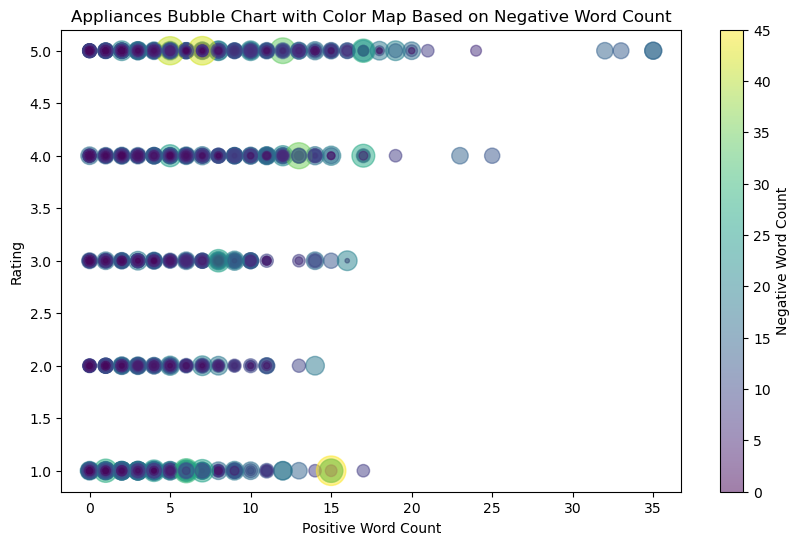

In [75]:
bubble_chart_plot(Appliances_row_count, 'Appliances')

### Baby Products

In [76]:
BP_row_count = get_rowbased_dataframe(BP)
BP_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   4.0|             0|             0|             true|
|   5.0|             1|             1|             true|
|   1.0|             1|             1|             true|
|   5.0|             2|             0|             true|
|   5.0|             2|             0|            false|
|   5.0|             0|             1|             true|
|   5.0|             1|             1|             true|
|   4.0|             2|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             2|             1|             true|
|   5.0|             0|             0|             true|
|   1.0|             1|             0|             true|
|   5.0|             0|             0|             true|
|   1.0|             1|        

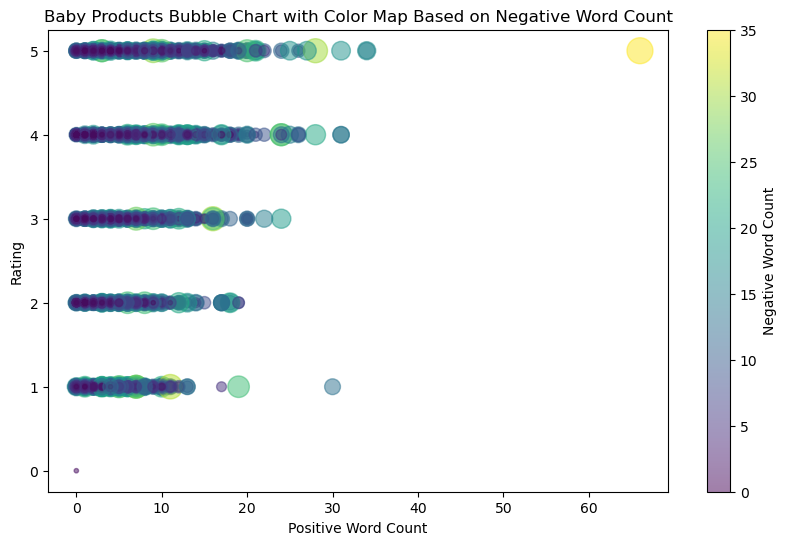

In [77]:
bubble_chart_plot(BP_row_count, 'Baby Products')

### Industrial and Scientific

In [78]:
Ind_S_row_count = get_rowbased_dataframe(Ind_S)
Ind_S_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   5.0|             0|             0|             true|
|   5.0|             1|             1|             true|
|   4.0|             1|             0|             true|
|   5.0|             0|             0|             true|
|   1.0|             0|             0|             true|
|   1.0|             0|             0|             true|
|   4.0|             1|             0|             true|
|   5.0|             1|             2|             true|
|   5.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   1.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             1|             0|             true|
|   3.0|             0|             0|             true|
|   4.0|             0|        

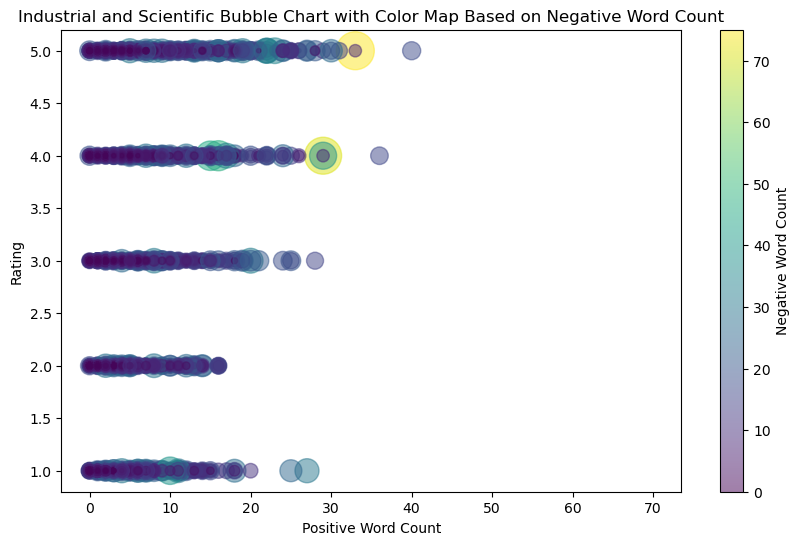

In [79]:
bubble_chart_plot(Ind_S_row_count, 'Industrial and Scientific')

### Musical Instruments

In [80]:
MI_row_count = get_rowbased_dataframe(MI)
MI_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   5.0|             0|             0|             true|
|   3.0|             1|             2|             true|
|   4.0|             1|             0|             true|
|   3.0|             0|             1|             true|
|   5.0|             1|             0|            false|
|   5.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             2|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             0|             0|            false|
|   5.0|             1|             0|            false|
|   5.0|             0|             0|             true|
|   5.0|             1|        

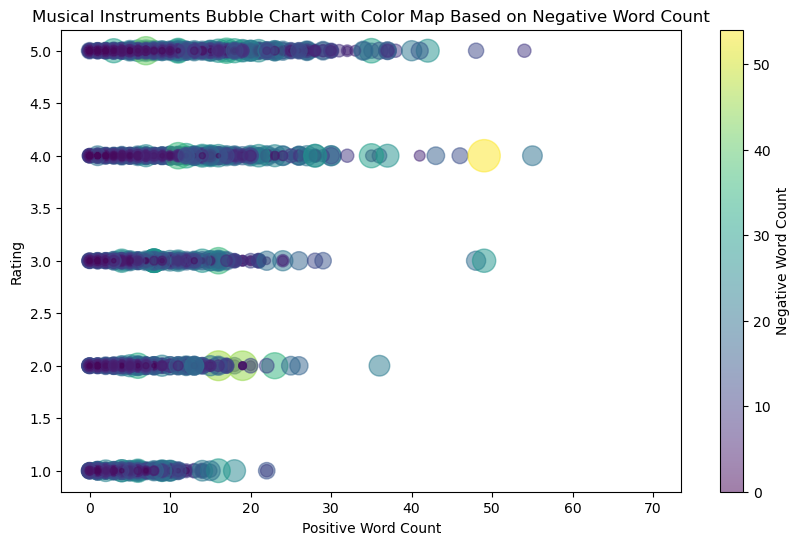

In [81]:
bubble_chart_plot(MI_row_count, 'Musical Instruments')

### Software

In [82]:
Software_row_count = get_rowbased_dataframe(Software)
Software_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   1.0|             0|             0|            false|
|   5.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   4.0|             1|             0|             true|
|   4.0|             1|             0|             true|
|   4.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   5.0|             2|             0|            false|
|   1.0|             1|             1|            false|
|   4.0|             0|             1|            false|
|   2.0|             1|             2|            false|
|   5.0|             1|             0|            false|
|   5.0|             0|             0|             true|
|   2.0|             4|             0|            false|
|   4.0|             1|        

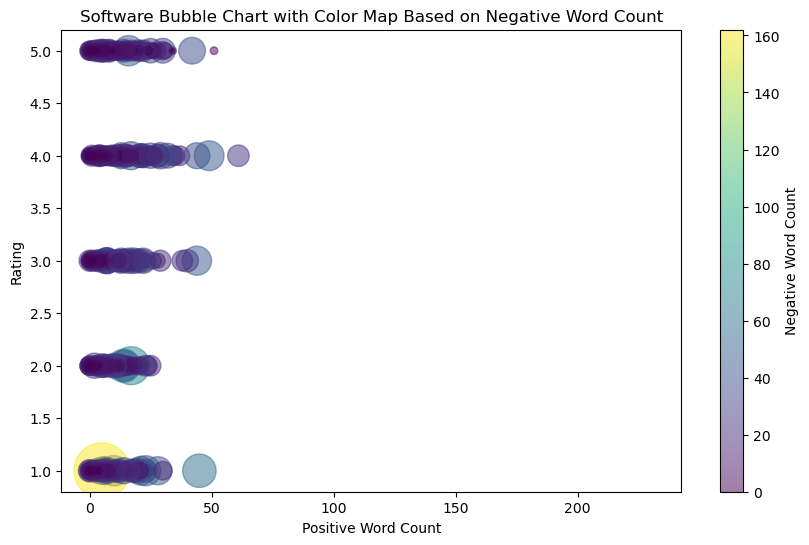

In [83]:
bubble_chart_plot(Software_row_count, 'Software')

### Video Games

In [84]:
VG_row_count = get_rowbased_dataframe(VG)
VG_row_count.show(20)

+------+--------------+--------------+-----------------+
|rating|pos_word_count|neg_word_count|verified_purchase|
+------+--------------+--------------+-----------------+
|   4.0|             1|             0|             true|
|   5.0|             1|             0|            false|
|   5.0|             1|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             1|             0|             true|
|   3.0|             0|             0|             true|
|   5.0|             0|             0|             true|
|   5.0|             0|             1|            false|
|   5.0|             1|             0|             true|
|   1.0|             1|             2|             true|
|   4.0|             1|             0|             true|
|   1.0|             0|             0|             true|
|   4.0|             0|             1|            false|
|   5.0|             0|             0|             true|
|   1.0|             0|        

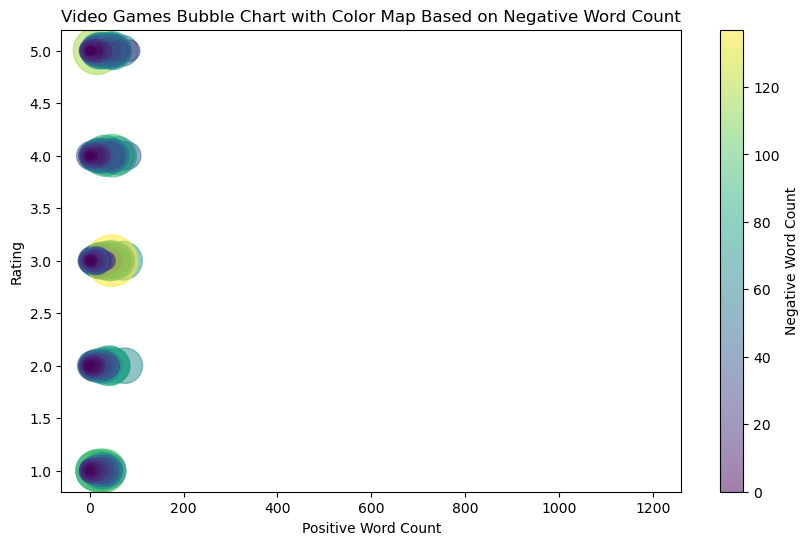

In [85]:
bubble_chart_plot(VG_row_count, 'Video Games')

According to the bubble graphs above, we can see that generally, each reviewer's rating has a postive correaltion with the number of positive words in his or her revirew and a negative correlation with the number of negative words in the review.

## **We will now move to the cross-industrial analysis of how 'Verified Purchase' Reviews dfiffer in rating and sentiment from Non-Verified Purchase Reviews.**

Function to use Spark SQL to aggregate the row results and check for whether buying or not have an effect on the positivity of prodmuct reviews and ratings.

In [86]:
def sql_agg(df):
    df.createOrReplaceTempView('temp_view')
    result_df = spark.sql("""
    SELECT  AVG(rating), 
            SUM(pos_word_count) AS pos_sum, 
            SUM(neg_word_count) AS neg_sum, 
            CASE
                WHEN SUM(neg_word_count) = 0 THEN NULL
                ELSE SUM(pos_word_count) / SUM(neg_word_count)
            END AS pos_neg_ratio,
            verified_purchase
    FROM temp_view
    GROUP BY verified_purchase
    """)

    return result_df

In [87]:
Appliances_agg_df = sql_agg(Appliances_row_count)
Appliances_agg_df.show()

+------------------+-------+-------+------------------+-----------------+
|       avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+------------------+-------+-------+------------------+-----------------+
|4.2515220110741625|1110756| 461812|2.4052125107186475|             true|
| 3.529822342191753|  76030|  69359|  1.09618074078346|            false|
+------------------+-------+-------+------------------+-----------------+



In [88]:
BP_agg_df = sql_agg(BP_row_count)
BP_agg_df.show()

+-----------------+-------+-------+------------------+-----------------+
|      avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+-----------------+-------+-------+------------------+-----------------+
|4.232785087880719|3318162|1255647| 2.642591428960528|             true|
|4.013285690263999| 584279| 307628|1.8993037044742351|            false|
+-----------------+-------+-------+------------------+-----------------+



In [89]:
Ind_S_agg_df = sql_agg(Ind_S_row_count)
Ind_S_agg_df.show()

+-----------------+-------+-------+------------------+-----------------+
|      avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+-----------------+-------+-------+------------------+-----------------+
|4.188646461642804|2503891|1152574|2.1724340476186343|             true|
|4.085825676318776| 267204| 152850|1.7481452404317959|            false|
+-----------------+-------+-------+------------------+-----------------+



In [90]:
MI_agg_df = sql_agg(MI_row_count)
MI_agg_df.show()

+-----------------+-------+-------+------------------+-----------------+
|      avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+-----------------+-------+-------+------------------+-----------------+
|4.269449724241732|1856805| 747015|2.4856328186181003|             true|
|4.092223666661039| 318220| 167626|1.8983928507510768|            false|
+-----------------+-------+-------+------------------+-----------------+



In [91]:
Software_agg_df = sql_agg(Software_row_count)
Software_agg_df.show()

+-----------------+-------+-------+------------------+-----------------+
|      avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+-----------------+-------+-------+------------------+-----------------+
|3.971734971468895|1886764|1031742|1.8287168691397655|             true|
|3.210349084716901| 215216| 228457|0.9420416095807964|            false|
+-----------------+-------+-------+------------------+-----------------+



In [92]:
VG_agg_df = sql_agg(VG_row_count)
VG_agg_df.show()

+------------------+-------+-------+------------------+-----------------+
|       avg(rating)|pos_sum|neg_sum|     pos_neg_ratio|verified_purchase|
+------------------+-------+-------+------------------+-----------------+
| 4.098450916652502|2393367|1511586|1.5833482183613767|             true|
|3.7310270361229527|1056139| 916893|1.1518672298730603|            false|
+------------------+-------+-------+------------------+-----------------+



According to the tables above, it is already apparent that reviewers without a verified purchase generally tend to give lower rating and their reviews are more negative, the result is the same for each industry. We will visualize the results in a more intuitive way by a scatter plot below.

In [93]:
colors = {True: 'blue', False: 'red'}
markers = {'Appliances': 'o', 'Baby Products': '^', 'Industrial and Scientific': 's', 'Musical Instruments': 'p', 'Software': '*', 'Video Games':'x'}

In [94]:
df1 = Appliances_agg_df.withColumn("industry", lit("Appliances"))
df2 = BP_agg_df.withColumn("industry", lit("Baby Products"))
df3 = Ind_S_agg_df.withColumn("industry", lit("Industrial and Scientific"))
df4 = MI_agg_df.withColumn("industry", lit("Musical Instruments"))
df5 = Software_agg_df.withColumn("industry", lit("Software"))
df6 = VG_agg_df.withColumn("industry", lit("Video Games"))

In [95]:
combined_df = df1.union(df2).union(df3).union(df4).union(df5).union(df6)

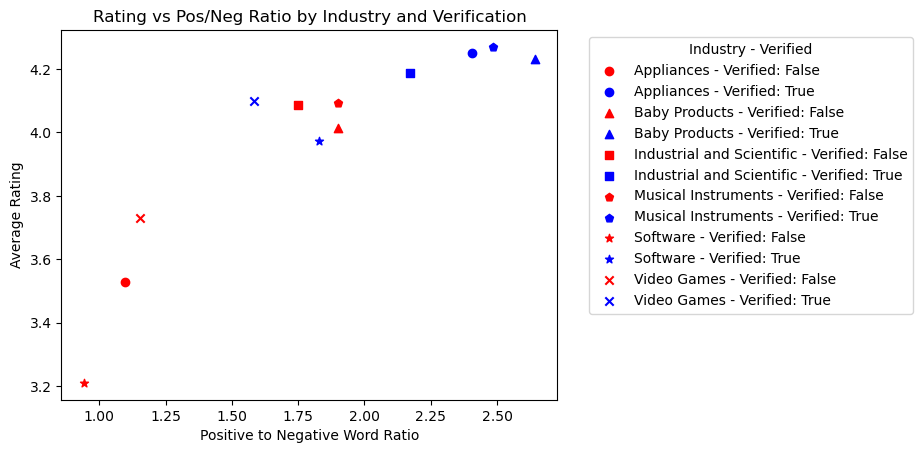

In [96]:
pandas_df = combined_df.toPandas()
fig, ax = plt.subplots()

# Loop through each portfolio, grouping plots based on industry and verified_purchase
for (industry, verified), group in pandas_df.groupby(['industry', 'verified_purchase']):
    ax.scatter(group['pos_neg_ratio'], group['avg(rating)'],
               color=colors[verified],
               marker=markers[industry],
               label=f'{industry} - Verified: {verified}')

# add the legend
ax.legend(title='Industry - Verified', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Positive to Negative Word Ratio')
ax.set_ylabel('Average Rating')
ax.set_title('Rating vs Pos/Neg Ratio by Industry and Verification')

plt.show()

According to this scatter graph, we can conclude that reviewers without a verified purchase generally tend to give lower rating and their reviews are more negative, indicating they may discredit products indiscriminately without purchasing them.

Stop the Spark Session before we close our programme.

In [97]:
spark.stop()